Обучение Random Forest на корпусе А 

In [34]:
# Установка библиотек

%pip install pandas openpyxl scikit-learn -q

import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

# Пути к файлам
corpus_path = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\corp_a.xlsx"
nom_path = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\nom a.xlsx"


# Загружаем корпус и оставляем только нужные колонки
df_corpus = pd.read_excel(corpus_path)
expected_corpus_cols = ['english', 'russian_1', 'russian_2', 'russian_3', 'nom.orig', 'nom.1', 'nom.2', 'nom.3']
# Оставляем только те колонки, которые есть в списке и существуют в файле
existing_corpus_cols = [col for col in expected_corpus_cols if col in df_corpus.columns]
df_corpus = df_corpus[existing_corpus_cols]

print(f" Корпус загружен: {df_corpus.shape[0]} строк, {df_corpus.shape[1]} колонок")
print(f"   Колонки: {list(df_corpus.columns)}")

# Загружаем таблицу номинаций
df_nom = pd.read_excel(nom_path)

# Оставляем только первые 4 колонки (original, 1, 2, 3)
# Предполагаем, что они идут в порядке: original, 1, 2, 3
df_nom = df_nom.iloc[:, :4]

# Переименовываем колонки для надежности
df_nom.columns = ['original', '1', '2', '3']

print(f" Таблица номинаций загружена: {df_nom.shape[0]} строк, {df_nom.shape[1]} колонок")
print(f"   Колонки: {list(df_nom.columns)}")
print(f"\nПервые 5 строк таблицы номинаций:")
print(df_nom.head())

 Корпус загружен: 2818 строк, 8 колонок
   Колонки: ['english', 'russian_1', 'russian_2', 'russian_3', 'nom.orig', 'nom.1', 'nom.2', 'nom.3']
 Таблица номинаций загружена: 416 строк, 4 колонок
   Колонки: ['original', '1', '2', '3']

Первые 5 строк таблицы номинаций:
         original                    1            2                 3
0  accursed Tower                  NaN          NaN   Проклятая Башня
1   accursed vale  околдованная долина          NaN  проклятая долина
2       Adventure          Приключение  Приключение       Приключение
3        Aglarond             Агларонд     Агларонд          Агларонд
4        Aldalómë            Аладоломэ    Альдаломэ          Алдаломэ


In [3]:
print("\nКорпус:")
for col in df_corpus.columns:
    print(f"  {col}: {df_corpus[col].dtype}")

print("\nТаблица номинаций:")
for col in df_nom.columns:
    print(f"  {col}: {df_nom[col].dtype}")
    # Покажем пример значения
    if len(df_nom) > 0:
        print(f"    пример: {df_nom[col].iloc[0]}")


Корпус:
  english: object
  russian_1: object
  russian_2: object
  russian_3: object
  nom.orig: object
  nom.1: object
  nom.2: object
  nom.3: object

Таблица номинаций:
  original: object
    пример: accursed Tower
  1: object
    пример: nan
  2: object
    пример: nan
  3: object
    пример: Проклятая Башня


In [4]:
# Функция для поиска номинации в тексте

def find_name_in_text(text, name_to_find):
    
    if pd.isna(text) or pd.isna(name_to_find) or not name_to_find:
        return False
    
    text = str(text).lower()
    name_to_find = str(name_to_find).lower()
    
    # Простой поиск (имя может быть частью слова)
    if name_to_find in text:
        return True
    
    # Пробуем искать с учетом общих окончаний
    # Для русских слов: убираем окончания для сравнения основы
    if len(name_to_find) > 4:
        # Берем основу (первые 4-5 букв) и ищем
        base = name_to_find[:4]
        if base in text:
            return True
    
    return False

# Тест функции
test_text = "Хоббиты встретили Гэндальфа"
test_name = "Гэндальф"
result = find_name_in_text(test_text, test_name)
print(f" Тест функции поиска: '{test_name}' в '{test_text}' → {result}")

 Тест функции поиска: 'Гэндальф' в 'Хоббиты встретили Гэндальфа' → True


In [ ]:
# Создание признаков
def create_features(df_corpus, df_nom):
    
    features_list = []
    labels_list = []
    names_info = []  # для отслеживания, какие имена использованы

    # Создаем словарь для быстрого доступа к переводам из таблицы номинаций
    nom_dict = {}
    for _, row in df_nom.iterrows():
        orig = row['original']
        # Проверяем, что значения не пустые
        nom_dict[orig] = {
            1: str(row['1']) if pd.notna(row['1']) and str(row['1']).strip() else None,
            2: str(row['2']) if pd.notna(row['2']) and str(row['2']).strip() else None,
            3: str(row['3']) if pd.notna(row['3']) and str(row['3']).strip() else None
        }
    
    print(f" Загружено {len(nom_dict)} уникальных имен из таблицы номинаций")
    
    # Для каждой строки в корпусе
    total_rows = len(df_corpus)
    for idx, row in df_corpus.iterrows():
        if idx % 50 == 0:
            print(f"  Обработано строк: {idx}/{total_rows}")
        
        original_name = row['nom.orig']  # английское имя из корпуса
        
        # Для каждого переводчика (1, 2, 3)
        for translator in [1, 2, 3]:
            text = row[f'russian_{translator}']
            nom_value = row[f'nom.{translator}']  # перевод имени из корпуса
            
            # Пропускаем, если нет текста или номинации
            if pd.isna(text) or not str(text).strip() or pd.isna(nom_value) or not str(nom_value).strip():
                continue
            
            text = str(text)
            nom_value = str(nom_value)
            
            # Базовый признак: найдено ли имя в тексте
            name_found = find_name_in_text(text, nom_value)
            
            # Признаки для конкретного имени
            features = {
                # Мета-информация (потом удалим)
                'translator': translator,
                'original_name': original_name,
                'nom_value': nom_value,
                'row_id': idx,
                
                # Признаки на основе текста
                'text_length': len(text),
                'word_count': len(text.split()),
                'name_found': 1 if name_found else 0,
                
                # Признаки на основе самой номинации
                'nom_length': len(nom_value),
            }
            
            # Добавляем признаки для каждого имени из таблицы номинаций
            for nom_orig, translations in nom_dict.items():
                trans_val = translations[translator]
                
                if trans_val is None:
                    continue
                
                # Признак: встретилось ли это имя в тексте
                feature_name = f'has_{nom_orig}'
                features[feature_name] = 1 if find_name_in_text(text, trans_val) else 0
            
            features_list.append(features)
            labels_list.append(translator)
            names_info.append({
                'original': original_name,
                'translation': nom_value,
                'translator': translator
            })
    
    print(f" Создано {len(features_list)} примеров")
    return features_list, labels_list, names_info

# Создаем признаки
features_list, labels_list, names_info = create_features(df_corpus, df_nom)

In [6]:
# Преобразуем список признаков в DataFrame
df_features = pd.DataFrame(features_list)

print(f"Форма df_features: {df_features.shape}")
print(f"\nПервые 5 колонок:")
print(df_features.columns[:5].tolist())

# Убираем колонки, которые не должны быть признаками
cols_to_drop = ['translator', 'original_name', 'nom_value', 'row_id']
X_cols = [col for col in df_features.columns if col not in cols_to_drop]

print(f"\n КОЛОНКИ ДЛЯ ОБУЧЕНИЯ:")
print(f"  Всего признаков: {len(X_cols)}")
print(f"  Признаков имён (has_*): {len([c for c in X_cols if c.startswith('has_')])}")
print(f"  Базовых признаков: {len([c for c in X_cols if not c.startswith('has_')])}")

# Проверяем на пропуски и заполняем нулями
df_features[X_cols] = df_features[X_cols].fillna(0)

# Создаем матрицу признаков X и целевую переменную y
X = df_features[X_cols]
y = np.array(labels_list)

print(f"\n РАЗМЕРНОСТЬ ДАННЫХ:")
print(f"  X: {X.shape} (примеры × признаки)")
print(f"  y: {y.shape} (метки)")

# Проверим распределение классов
unique, counts = np.unique(y, return_counts=True)
print("\n РАСПРЕДЕЛЕНИЕ ПЕРЕВОДЧИКОВ:")
for t, c in zip(unique, counts):
    print(f"  Переводчик {t}: {c} примеров ({c/len(y)*100:.1f}%)")

Форма df_features: (4922, 365)

Первые 5 колонок:
['translator', 'original_name', 'nom_value', 'row_id', 'text_length']

 КОЛОНКИ ДЛЯ ОБУЧЕНИЯ:
  Всего признаков: 361
  Признаков имён (has_*): 357
  Базовых признаков: 4

 РАЗМЕРНОСТЬ ДАННЫХ:
  X: (4922, 361) (примеры × признаки)
  y: (4922,) (метки)

 РАСПРЕДЕЛЕНИЕ ПЕРЕВОДЧИКОВ:
  Переводчик 1: 1865 примеров (37.9%)
  Переводчик 2: 1408 примеров (28.6%)
  Переводчик 3: 1649 примеров (33.5%)


In [7]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% на тест
    random_state=42,         # для воспроизводимости
    stratify=y               # сохраняем пропорции классов
)

print(f"  Обучающая выборка: {X_train.shape[0]} примеров")
print(f"  Тестовая выборка: {X_test.shape[0]} примеров")

# Проверим распределение в тесте
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\n РАСПРЕДЕЛЕНИЕ В ТЕСТОВОЙ ВЫБОРКЕ:")
for t, c in zip(unique_test, counts_test):
    print(f"  Переводчик {t}: {c} примеров ({c/len(y_test)*100:.1f}%)")

  Обучающая выборка: 3937 примеров
  Тестовая выборка: 985 примеров

 РАСПРЕДЕЛЕНИЕ В ТЕСТОВОЙ ВЫБОРКЕ:
  Переводчик 1: 373 примеров (37.9%)
  Переводчик 2: 282 примеров (28.6%)
  Переводчик 3: 330 примеров (33.5%)


In [8]:
# Создаем модель Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,        # количество деревьев
    max_depth=10,            # максимальная глубина
    min_samples_split=5,      # минимальное количество для разделения
    min_samples_leaf=2,       # минимальное количество в листе
    random_state=42,
    n_jobs=-1               
)

print("Обучение")
rf_model.fit(X_train, y_train)
print("Модель обучена!")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n10 самых важных признаков:")
print(feature_importance.head(10).to_string(index=False))

Обучение
Модель обучена!

10 самых важных признаков:
                       feature  importance
                      has_Dale    0.072564
has_notice and a list of Rules    0.054918
                   has_Bag End    0.052981
                  has_Hobbiton    0.046198
                     has_Shire    0.038630
                   has_Dimholt    0.038347
                has_Great Horn    0.033868
                   has_New Age    0.031036
               has_Cross-roads    0.027441
                    has_Hobbit    0.026515


In [9]:
# Предсказания на тестовой выборке
y_pred = rf_model.predict(X_test)

# Метрики
accuracy = accuracy_score(y_test, y_pred)

print(f" Точность: {accuracy:.2%}")
print(f"   (случайное угадывание: 33%)")


# Детальный отчет
print(classification_report(y_test, y_pred, 
                          target_names=['Переводчик 1', 'Переводчик 2', 'Переводчик 3']))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
print("\n МАТРИЦА ОШИБОК:")

print("           ПРЕДСКАЗАНО")
print("          1    2    3")
for i, row in enumerate(cm, 1):
    print(f"Реально {i}: {row}")

 Точность: 59.09%
   (случайное угадывание: 33%)
              precision    recall  f1-score   support

Переводчик 1       0.51      0.99      0.67       373
Переводчик 2       0.77      0.18      0.29       282
Переводчик 3       0.86      0.49      0.62       330

    accuracy                           0.59       985
   macro avg       0.71      0.55      0.53       985
weighted avg       0.70      0.59      0.55       985


 МАТРИЦА ОШИБОК:
           ПРЕДСКАЗАНО
          1    2    3
Реально 1: [369   1   3]
Реально 2: [207  51  24]
Реально 3: [154  14 162]


In [10]:
# Создаем DataFrame с результатами на тесте
test_results = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
    'correct': y_test == y_pred
})

# Добавляем информацию об именах из тестовой выборки
test_indices = X_test.index
test_names = []
for idx in test_indices:
    if idx < len(names_info):
        test_names.append(names_info[idx])
    else:
        test_names.append({'original': 'unknown', 'translation': 'unknown', 'translator': -1})

test_results['original_name'] = [info['original'] for info in test_names]
test_results['translation'] = [info['translation'] for info in test_names]

# Точность по разным именам
name_accuracy = test_results.groupby('original_name')['correct'].agg(['mean', 'count'])
name_accuracy = name_accuracy[name_accuracy['count'] >= 3]
name_accuracy = name_accuracy.sort_values('mean', ascending=False)

print(f"\n10 точных имен:")
for i, (name, row) in enumerate(name_accuracy.head(10).iterrows(), 1):
    print(f"  {i:2}. {name:20} - {row['mean']*100:5.1f}% ({row['count']:3} примеров)")


10 точных имен:
   1. Guard                - 100.0% (4.0 примеров)
   2. Treebeard            - 100.0% (3.0 примеров)
   3. Sauron               - 100.0% (6.0 примеров)
   4. River                - 100.0% (5.0 примеров)
   5. Black Rider          - 100.0% (5.0 примеров)
   6. Isildur              - 100.0% (3.0 примеров)
   7. Imrahil              - 100.0% (4.0 примеров)
   8. precious             -  83.3% (6.0 примеров)
   9. Mindolluin           -  83.3% (6.0 примеров)
  10. King                 -  80.0% (10.0 примеров)


In [11]:
# Тест на изолированных номинациях=

def test_on_isolated_names(model, df_nom, names_in_corpus, X_cols):

    test_data = []
    
    for _, row in df_nom.iterrows():
        orig = row['original']
        
        # Пропускаем имена, которые были в корпусе
        if orig in names_in_corpus:
            continue
            
        for translator in [1, 2, 3]:
            trans = row[str(translator)]
            if pd.isna(trans) or not trans:
                continue
            
            # Создаем минимальный набор признаков
            features = {}
            
            # Добавляем признаки для всех имён
            for _, nom_row in df_nom.iterrows():
                orig_check = nom_row['original']
                trans_check = nom_row[str(translator)]
                
                if pd.isna(trans_check) or not trans_check:
                    continue
                    
                features[f'has_{orig_check}'] = 1 if orig_check == orig else 0
            
            # Добавляем базовые признаки
            features['text_length'] = len(trans)
            features['word_count'] = 1
            features['nom_length'] = len(trans)
            features['name_found'] = 1
            
            test_data.append({
                'features': features,
                'true': translator,
                'name': trans,
                'original': orig
            })
    
    if not test_data:
        print(" Нет новых имён для тестирования!")
        return None, None
    
    # Подготовка данных
    X_test_names = pd.DataFrame([d['features'] for d in test_data])
    
    # Добавляем недостающие колонки
    for col in X_cols:
        if col not in X_test_names.columns:
            X_test_names[col] = 0
    
    X_test_names = X_test_names[X_cols]
    y_test_names = [d['true'] for d in test_data]
    
    # Предсказание
    y_pred_names = model.predict(X_test_names)
    accuracy = accuracy_score(y_test_names, y_pred_names)
    
    print(f"\n Точность на изолированных именах: {accuracy:.2%}")
    print(f"   Тестовых примеров: {len(y_test_names)}")
    print(f"   Уникальных новых имён: {len(set([d['original'] for d in test_data]))}")
    
    return test_data, y_pred_names

# Получаем список имён из корпуса
names_in_corpus = set(df_corpus['nom.orig'].unique())
print(f"  Имён в корпусе: {len(names_in_corpus)}")
print(f"  Всего имён в словаре: {len(df_nom)}")
print(f"  Новых имён для теста: {len(df_nom) - len(names_in_corpus)}")

# Запускаем тест
test_data, y_pred_names = test_on_isolated_names(rf_model, df_nom, names_in_corpus, X_cols)

  Имён в корпусе: 436
  Всего имён в словаре: 416
  Новых имён для теста: -20

 Точность на изолированных именах: 32.14%
   Тестовых примеров: 28
   Уникальных новых имён: 10


In [12]:
import joblib
import os
from datetime import datetime

# Папка для сохранения результатов
output_dir = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results"
os.makedirs(output_dir, exist_ok=True)

# Создаем подпапку с датой и временем
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(output_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

print(f"СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В: {run_dir}")

# Сохраняем модель
model_path = os.path.join(run_dir, 'random_forest_model.pkl')
joblib.dump(rf_model, model_path)
print(f"  Модель сохранена")

# Сохраняем важность признаков
feature_importance.to_csv(os.path.join(run_dir, 'feature_importance.csv'), 
                         index=False, encoding='utf-8-sig')
print(f"  Важность признаков сохранена")

# Сохраняем результаты теста
test_results.to_excel(os.path.join(run_dir, 'test_results.xlsx'), index=False)
print(f"  Результаты теста сохранены")

print(f"\nВсе файлы сохранены в папке:\n{run_dir}")

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В: C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647
  Модель сохранена
  Важность признаков сохранена
  Результаты теста сохранены

Все файлы сохранены в папке:
C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647


In [13]:
# Пример предсказания
def predict_translator(model, text, df_nom, X_cols):
    
    # Создаем признаки для этого текста
    features = {}
    
    # Добавляем признаки для всех имён из словаря
    for _, nom_row in df_nom.iterrows():
        orig = nom_row['original']
        
        # Проверяем для всех трёх переводчиков
        found = False
        for t in [1,2,3]:
            trans = nom_row[str(t)]
            if pd.notna(trans) and trans and trans.lower() in text.lower():
                found = True
                break
        features[f'has_{orig}'] = 1 if found else 0
    
    # Добавляем базовые признаки
    features['text_length'] = len(text)
    features['word_count'] = len(text.split())
    features['nom_length'] = 0
    features['name_found'] = 1 if any(features.values()) else 0
    
    # Преобразуем в DataFrame
    X_pred = pd.DataFrame([features])
    
    # Добавляем недостающие колонки
    for col in X_cols:
        if col not in X_pred.columns:
            X_pred[col] = 0
    
    X_pred = X_pred[X_cols]
    
    # Предсказание
    pred = model.predict(X_pred)[0]
    proba = model.predict_proba(X_pred)[0]
    

    print(f"\n Текст: {text}")
    print(f"\n Результат:")
    print(f"  Предсказанный переводчик: {pred}")
    print(f"  Уверенность:")
    for i, p in enumerate(proba, 1):
        print(f"    Переводчик {i}: {p:.2%}")
    
    return pred, proba

# Пример использования
test_text = "Гэндальф отправился в Шир и встретил там хоббитов"
pred, proba = predict_translator(rf_model, test_text, df_nom, X_cols)


 Текст: Гэндальф отправился в Шир и встретил там хоббитов

 Результат:
  Предсказанный переводчик: 1
  Уверенность:
    Переводчик 1: 57.55%
    Переводчик 2: 21.49%
    Переводчик 3: 20.95%


Проверка модели на корпусе Б (параллельные фрагменты с другим набором номинаций)

In [14]:
# Путь к корпусу Б
corpus_b_path = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\corp_b.xlsx"

# Загружаем корпус Б
df_corpus_b = pd.read_excel(corpus_b_path)

# Оставляем только нужные колонки
expected_cols = ['english', 'russian_1', 'russian_2', 'russian_3', 'nom.orig', 'nom.1', 'nom.2', 'nom.3']
existing_cols = [col for col in expected_cols if col in df_corpus_b.columns]
df_corpus_b = df_corpus_b[existing_cols]

print(f" Корпус Б загружен: {df_corpus_b.shape[0]} строк, {df_corpus_b.shape[1]} колонок")
print(f"   Колонки: {list(df_corpus_b.columns)}")

# Покажем первые 2 строки для проверки
print("\n Первые 2 строки корпуса Б:")
print(df_corpus_b.head(2))

 Корпус Б загружен: 506 строк, 8 колонок
   Колонки: ['english', 'russian_1', 'russian_2', 'russian_3', 'nom.orig', 'nom.1', 'nom.2', 'nom.3']

 Первые 2 строки корпуса Б:
                                             english  \
0  A host of the enemy was encamped upon it, thre...   
1  It was late in the afternoon when the leaders ...   

                                           russian_1  \
0  Выслали дозорных: одни не вернулись, другие пр...   
1  Уже под вечер передовые углубились в серую чащ...   

                                           russian_2  \
0  В трех милях западнее Амон Дина стоит целая ор...   
1  Поначалу Всадники замешкались, путаясь в густо...   

                                           russian_3  nom.orig     nom.1  \
0  Некоторые не вернулись; остальные в спешке при...  Amon Dîn  Амон-Дин   
1  Было уже далеко за полдень, когда головной эор...  Amon Dîn  Амон-Дин   

      nom.2     nom.3  
0  Амон Дин  Амон Дин  
1  Амон Дин  Амон Дин  


In [15]:
# Проверяем, есть ли пустые значения
print("\n Пустые значения в nom.1, nom.2, nom.3:")
print(f"  nom.1: {df_corpus_b['nom.1'].isna().sum()} пустых из {len(df_corpus_b)}")
print(f"  nom.2: {df_corpus_b['nom.2'].isna().sum()} пустых из {len(df_corpus_b)}")
print(f"  nom.3: {df_corpus_b['nom.3'].isna().sum()} пустых из {len(df_corpus_b)}")

# Проверяем уникальные имена
unique_names = df_corpus_b['nom.orig'].unique()
print(f"\n Уникальных имен в корпусе Б: {len(unique_names)}")
print(f"   Первые 10 имен: {list(unique_names[:10])}")

# Проверяем пересечение с корпусом А
names_in_a = set(df_corpus['nom.orig'].unique()) if 'df_corpus' in dir() else set()
names_in_b = set(unique_names)
overlap = names_in_a & names_in_b

print(f"\n Пересечение имен с корпусом А: {len(overlap)}")
if len(overlap) > 0:
    print(f"   Общие имена: {list(overlap)[:10]}")
else:
    print("    Имена полностью новые (нет пересечений)")


 Пустые значения в nom.1, nom.2, nom.3:
  nom.1: 67 пустых из 506
  nom.2: 148 пустых из 506
  nom.3: 102 пустых из 506

 Уникальных имен в корпусе Б: 48
   Первые 10 имен: ['Amon Dîn', 'Amon Hen', 'Anfalas', 'Anórien', 'Aragorn', 'Arathorn', 'Bagshot Row', 'Brandybuck', 'Brandywine', 'Brandywine Bridge']

 Пересечение имен с корпусом А: 0
    Имена полностью новые (нет пересечений)


In [ ]:
# Подготовка данных

def prepare_corpus_b_for_prediction(df_corpus_b, df_nom, X_cols):
   
    # Создаем словарь номинаций из таблицы nom (нужен только для создания признаков has_*)
    nom_dict = {}
    for _, row in df_nom.iterrows():
        orig = row['original']
        nom_dict[orig] = {
            1: str(row['1']) if pd.notna(row['1']) and str(row['1']).strip() else None,
            2: str(row['2']) if pd.notna(row['2']) and str(row['2']).strip() else None,
            3: str(row['3']) if pd.notna(row['3']) and str(row['3']).strip() else None
        }
    
    print(f" Используется словарь с {len(nom_dict)} именами из таблицы nom")
    
    features_list = []
    true_labels_list = []
    names_info_list = []
    
    total_rows = len(df_corpus_b)
    
    for idx, row in df_corpus_b.iterrows():
        if idx % 20 == 0:
            print(f"  Обработано строк: {idx}/{total_rows}")
        
        original_name = row['nom.orig']  # для информации, не для модели!
        
        # Для каждого переводчика
        for translator in [1, 2, 3]:
            text = row[f'russian_{translator}']
            
            # Пропускаем пустые тексты
            if pd.isna(text) or not str(text).strip():
                continue
            
            text = str(text)
            
        
            features = {
                # Мета-информация (не для модели)
                'true_translator': translator,
                'original_name': original_name,
                'row_id': idx,
                
                # Базовые признаки (те же, что в обучении)
                'text_length': len(text),
                'word_count': len(text.split()),
                'name_found': 0,  # будет переопределено ниже
                'nom_length': 0,   # для новых имен не знаем длину
            }
            
            # Добавляем признаки has_ для каждого имени из таблицы nom
            for nom_orig, translations in nom_dict.items():
                # Проверяем для текущего переводчика
                trans_val = translations[translator]
                
                if trans_val is None:
                    features[f'has_{nom_orig}'] = 0
                else:
                    # Ищем это имя в тексте
                    features[f'has_{nom_orig}'] = 1 if find_name_in_text(text, trans_val) else 0
            
            # Переопределяем name_found (было ли найдено хотя бы одно имя)
            name_features = [v for k, v in features.items() if k.startswith('has_')]
            features['name_found'] = 1 if any(name_features) else 0
            
            features_list.append(features)
            true_labels_list.append(translator)
            names_info_list.append({
                'original': original_name,
                'translator': translator,
                'text': text[:100] + '...' if len(text) > 100 else text
            })
    
    print(f"Подготовлено {len(features_list)} примеров")
    return features_list, true_labels_list, names_info_list

# Подготавливаем данные
features_list_b, true_labels_b, names_info_b = prepare_corpus_b_for_prediction(
    df_corpus_b, df_nom, X_cols
)

In [17]:
# Создаем DataFrame из признаков
df_features_b = pd.DataFrame(features_list_b)

print(f"Форма df_features_b: {df_features_b.shape}")
print(f"Колонки: {list(df_features_b.columns[:10])}...")

# Убираем мета-колонки, оставляем только признаки
meta_cols = ['true_translator', 'original_name', 'row_id']
feature_cols_b = [col for col in df_features_b.columns if col not in meta_cols]

# Проверяем, все ли нужные колонки есть
missing_cols = set(X_cols) - set(feature_cols_b)
if missing_cols:
    print(f"\n Отсутствуют колонки: {missing_cols}")
    # Добавляем недостающие колонки с нулями
    for col in missing_cols:
        df_features_b[col] = 0
else:
    print(f"\nВсе нужные колонки присутствуют")

# Убеждаемся, что колонки идут в том же порядке, что и в обучении
X_b = df_features_b[X_cols]
y_b_true = df_features_b['true_translator'].values

print(f"\n Размерность X_b: {X_b.shape}")
print(f" Размерность y_b_true: {y_b_true.shape}")

# Проверка распределения
unique_b, counts_b = np.unique(y_b_true, return_counts=True)
print("\n Распределение переводчиков в корпусе Б:")
for t, c in zip(unique_b, counts_b):
    print(f"  Переводчик {t}: {c} примеров ({c/len(y_b_true)*100:.1f}%)")

Форма df_features_b: (1518, 418)
Колонки: ['true_translator', 'original_name', 'row_id', 'text_length', 'word_count', 'name_found', 'nom_length', 'has_accursed Tower', 'has_accursed vale', 'has_Adventure']...

Все нужные колонки присутствуют

 Размерность X_b: (1518, 361)
 Размерность y_b_true: (1518,)

 Распределение переводчиков в корпусе Б:
  Переводчик 1: 506 примеров (33.3%)
  Переводчик 2: 506 примеров (33.3%)
  Переводчик 3: 506 примеров (33.3%)


In [18]:
# Получаем предсказания
y_b_pred = rf_model.predict(X_b)
y_b_proba = rf_model.predict_proba(X_b)

print(f" Предсказания получены для {len(y_b_pred)} примеров")

# Считаем метрики
accuracy_b = accuracy_score(y_b_true, y_b_pred)
print(f"\nТочность на корпусе Б: {accuracy_b:.2%}")
print(f"   (случайное угадывание: 33%)")
print(f"   (точность на корпусе А: 58.05%)")

# Сравнение
if accuracy_b > 0.5:
    print("\nМодель хорошо обобщает новые имена")
elif accuracy_b > 0.4:
    print("\n Модель частично обобщает")
else:
    print("\n Модель не обобщает - просто запомнила имена")

 Предсказания получены для 1518 примеров

Точность на корпусе Б: 51.45%
   (случайное угадывание: 33%)
   (точность на корпусе А: 58.05%)

Модель хорошо обобщает новые имена


In [35]:
# Classification Report
print("\n Classification Report:")
print(classification_report(y_b_true, y_b_pred, 
                          target_names=['Переводчик 1', 'Переводчик 2', 'Переводчик 3']))

# Матрица ошибок
cm_b = confusion_matrix(y_b_true, y_b_pred)
print("\n МАТРИЦА ОШИБОК (корпус Б):")
print("           ПРЕДСКАЗАНО")
print("          1    2    3")
for i, row in enumerate(cm_b, 1):
    print(f"Реально {i}: {row}")

# Сравнение с корпусом А
print("\n СРАВНЕНИЕ С КОРПУСОМ А:")
print(f"  Корпус А (известные имена): 58.05%")
print(f"  Корпус Б (новые имена):     {accuracy_b:.2%}")
print(f"  Разница:                    {accuracy_b*100 - 58.05:+.2f}%")


 Classification Report:
              precision    recall  f1-score   support

Переводчик 1       0.42      0.99      0.59       506
Переводчик 2       0.87      0.13      0.22       506
Переводчик 3       0.91      0.42      0.58       506

    accuracy                           0.51      1518
   macro avg       0.73      0.51      0.46      1518
weighted avg       0.73      0.51      0.46      1518


 МАТРИЦА ОШИБОК (корпус Б):
           ПРЕДСКАЗАНО
          1    2    3
Реально 1: [502   0   4]
Реально 2: [425  65  16]
Реально 3: [282  10 214]

 СРАВНЕНИЕ С КОРПУСОМ А:
  Корпус А (известные имена): 58.05%
  Корпус Б (новые имена):     51.45%
  Разница:                    -6.60%


In [20]:
# Создаем DataFrame с результатами
results_b = pd.DataFrame({
    'true': y_b_true,
    'pred': y_b_pred,
    'correct': y_b_true == y_b_pred,
    'original_name': [info['original'] for info in names_info_b],
    'text_sample': [info['text'] for info in names_info_b]
})

print(" АНАЛИЗ ПО ИМЕНАМ В КОРПУСЕ Б")

# Точность по разным именам
name_accuracy_b = results_b.groupby('original_name')['correct'].agg(['mean', 'count'])
name_accuracy_b = name_accuracy_b[name_accuracy_b['count'] >= 2]
name_accuracy_b = name_accuracy_b.sort_values('mean', ascending=False)

print(f"\n5 точных имен (высокая точность):")
for i, (name, row) in enumerate(name_accuracy_b.head(5).iterrows(), 1):
    print(f"  {i:2}. {name:20} - {row['mean']*100:5.1f}% ({row['count']:2} примеров)")

print(f"\n5 самых неточных имен (низкая точность):")
for i, (name, row) in enumerate(name_accuracy_b.tail(5).iterrows(), 1):
    print(f"  {i:2}. {name:20} - {row['mean']*100:5.1f}% ({row['count']:2} примеров)")

# Анализ ошибок
print("\n ПРИМЕРЫ ОШИБОК:")
errors_b = results_b[results_b['correct'] == False].head(10)
for i, (idx, row) in enumerate(errors_b.iterrows(), 1):
    print(f"\n  Ошибка {i}: {row['original_name']}")
    print(f"    Истина: {row['true']}, Предсказано: {row['pred']}")
    print(f"    Текст: {row['text_sample']}")

 АНАЛИЗ ПО ИМЕНАМ В КОРПУСЕ Б

5 точных имен (высокая точность):
   1. Snowmane             - 100.0% (6.0 примеров)
   2. Brandywine Bridge    - 100.0% (3.0 примеров)
   3. Morgul-road          -  83.3% (6.0 примеров)
   4. Ephel Dúath          -  75.0% (12.0 примеров)
   5. Amon Dîn             -  66.7% (12.0 примеров)

5 самых неточных имен (низкая точность):
   1. Amon Hen             -  33.3% (9.0 примеров)
   2. Sméagol              -  33.3% (78.0 примеров)
   3. Samwise the Strong   -  33.3% (3.0 примеров)
   4. Samwise              -  33.3% (3.0 примеров)
   5. éored                -  33.3% (3.0 примеров)

 ПРИМЕРЫ ОШИБОК:

  Ошибка 1: Amon Dîn
    Истина: 2, Предсказано: 1
    Текст: В трех милях западнее Амон Дина стоит целая орда, а большой отряд орков идет навстречу.

  Ошибка 2: Amon Dîn
    Истина: 2, Предсказано: 1
    Текст: Поначалу Всадники замешкались, путаясь в густом кустарнике, и только далеко за полдень первые отряды...

  Ошибка 3: Amon Dîn
    Истина: 2, Предска

In [21]:
# Анализ предсказаний по переводчикам

for translator in [1, 2, 3]:
    # Примеры этого переводчика
    translator_examples = results_b[results_b['true'] == translator]
    correct = translator_examples['correct'].sum()
    total = len(translator_examples)
    
    print(f"\nПЕРЕВОДЧИК {translator}:")
    print(f"  Правильно: {correct}/{total} = {correct/total*100:.1f}%")
    
    # Распределение предсказаний
    pred_dist = translator_examples['pred'].value_counts().sort_index()
    print(f"  Распределение предсказаний:")
    for t in [1, 2, 3]:
        count = pred_dist.get(t, 0)
        print(f"    Предсказано {t}: {count} ({count/total*100:.1f}%)")
    
    # Примеры ошибок
    errors = translator_examples[translator_examples['correct'] == False].head(3)
    if len(errors) > 0:
        print(f"  Примеры ошибок:")
        for _, row in errors.iterrows():
            print(f"    - Предсказано {row['pred']}: {row['text_sample']}")


ПЕРЕВОДЧИК 1:
  Правильно: 502/506 = 99.2%
  Распределение предсказаний:
    Предсказано 1: 502 (99.2%)
    Предсказано 2: 0 (0.0%)
    Предсказано 3: 4 (0.8%)
  Примеры ошибок:
    - Предсказано 3: Исторбинка зияла песчаным карьером; громоздились груды щебня.
    - Предсказано 3: Но я из нас самый старый, многие онты куда помоложе, на сотни древесных веков.
    - Предсказано 3: – Видишь ли – наши Безмолвные Соглядатаи встревожились пораньше назгула, дня два назад, это я точно ...

ПЕРЕВОДЧИК 2:
  Правильно: 65/506 = 12.8%
  Распределение предсказаний:
    Предсказано 1: 425 (84.0%)
    Предсказано 2: 65 (12.8%)
    Предсказано 3: 16 (3.2%)
  Примеры ошибок:
    - Предсказано 1: В трех милях западнее Амон Дина стоит целая орда, а большой отряд орков идет навстречу.
    - Предсказано 1: Поначалу Всадники замешкались, путаясь в густом кустарнике, и только далеко за полдень первые отряды...
    - Предсказано 1: Вот огонь на Амон Дине, пламя на Эленахе, и дальше огни, Нардол, Эрелас, Мин 

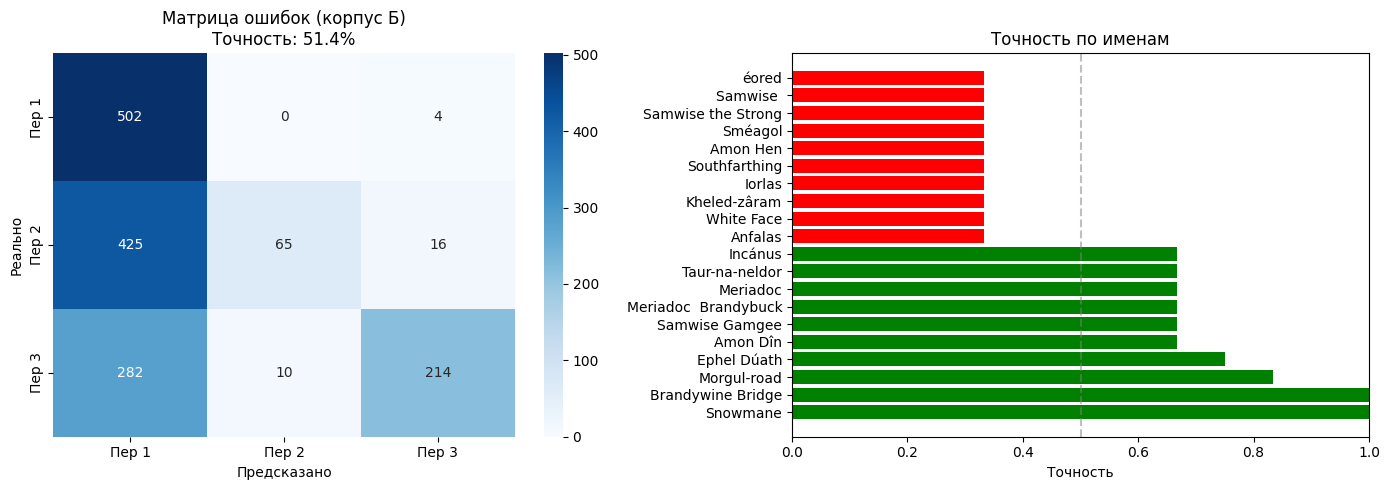

 Визуализация сохранена в C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647


In [22]:
# Визуализация

import matplotlib.pyplot as plt
import seaborn as sns
    
# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
# 1. Матрица ошибок для корпуса Б
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Пер 1', 'Пер 2', 'Пер 3'],
            yticklabels=['Пер 1', 'Пер 2', 'Пер 3'],
            ax=axes[0])
axes[0].set_title(f'Матрица ошибок (корпус Б)\nТочность: {accuracy_b:.1%}')
axes[0].set_xlabel('Предсказано')
axes[0].set_ylabel('Реально')
    
# 2. Сравнение точности по именам
top_names = name_accuracy_b.head(10).copy()
bottom_names = name_accuracy_b.tail(10).copy()
    
# Объединяем для наглядности
comparison = pd.concat([top_names, bottom_names])
colors = ['green' if x > 0.5 else 'red' for x in comparison['mean']]
    
axes[1].barh(range(len(comparison)), comparison['mean'].values, color=colors)
axes[1].set_yticks(range(len(comparison)))
axes[1].set_yticklabels(comparison.index)
axes[1].set_xlabel('Точность')
axes[1].set_title('Точность по именам')
axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlim(0, 1)
    
plt.tight_layout()
plt.savefig(os.path.join(run_dir, 'corpus_b_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
    
print(f" Визуализация сохранена в {run_dir}")
    


In [23]:
# Сохраняем результаты 
results_b_path = os.path.join(run_dir, 'corpus_b_predictions.xlsx')
results_b.to_excel(results_b_path, index=False)
print(f" Предсказания сохранены: {results_b_path}")

# Сохраняем отчет
report_path = os.path.join(run_dir, 'corpus_b_report.txt')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("ОТЧЕТ ПО КОРПУСУ Б (НОВЫЕ ИМЕНА)\n")
    f.write("="*60 + "\n\n")
    f.write(f"Точность: {accuracy_b:.2%}\n")
    f.write(f"Сравнение с корпусом А: {accuracy_b - 58.05:+.2f}%\n\n")
    
    f.write("Classification Report:\n")
    f.write(classification_report(y_b_true, y_b_pred))
    f.write("\n")
    
    f.write("Матрица ошибок:\n")
    f.write(str(cm_b))
    f.write("\n\n")
    
    f.write("10 самых точных имен:\n")
    for name, row in name_accuracy_b.head(10).iterrows():
        f.write(f"  {name}: {row['mean']*100:.1f}% ({row['count']} примеров)\n")

print(f" Отчет сохранен: {report_path}")

 Предсказания сохранены: C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647\corpus_b_predictions.xlsx
 Отчет сохранен: C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647\corpus_b_report.txt


Проверка на корпусе С с замаскированными номинациями

In [24]:
# Путь к корпусу С
corpus_c_path = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\corp_с_masked.xlsx"


# Загружаем корпус С
df_corpus_c = pd.read_excel(corpus_c_path)

# Оставляем только нужные колонки
expected_cols_c = ['english', 'russian_1', 'russian_2', 'russian_3']
existing_cols_c = [col for col in expected_cols_c if col in df_corpus_c.columns]
df_corpus_c = df_corpus_c[existing_cols_c]

print(f" Корпус С загружен: {df_corpus_c.shape[0]} строк, {df_corpus_c.shape[1]} колонок")
print(f"   Колонки: {list(df_corpus_c.columns)}")

# Покажем первые 2 строки для проверки
print("\n Первые 2 строки корпуса С (с маскировкой):")
print(df_corpus_c.head(2))

# Проверим наличие маскировки
sample_text = df_corpus_c['russian_1'].iloc[0] if len(df_corpus_c) > 0 else ""
print(f"\n Пример замаскированного текста:")
print(f"   {sample_text[:200]}...")

 Корпус С загружен: 374 строк, 4 колонок
   Колонки: ['english', 'russian_1', 'russian_2', 'russian_3']

 Первые 2 строки корпуса С (с маскировкой):
                                             english  \
0  And in the morning the banner of Dol Amroth, a...   
1  Faramir turned to the man at his side. ‘Now wh...   

                                           russian_1  \
0  А утром над шпилем [nom] развевалось знамя [no...   
1  [nom] повернулся к часовому: – Теперь что скаж...   

                                           russian_2  \
0  А утром перед [nom] развевалось знамя [nom] с ...   
1  [nom] обратился к воину, стоявшему рядом: – Ну...   

                                           russian_3  
0  А рано утром на [nom] взвился флаг [nom] — бел...  
1  [nom] спросил часового: – Что ты теперь скажеш...  

 Пример замаскированного текста:
   А утром над шпилем [nom] развевалось знамя [nom], голубое с белым кораблем, подобным лебедю; [nom] смотрели на него и думали – неужто приснило

In [ ]:
# Подготовка данных корпуса С для предсказания

def prepare_corpus_c_for_prediction(df_corpus_c, df_nom, X_cols):

    
    # Создаем словарь номинаций из таблицы nom (нужен только для создания структуры признаков)
    nom_dict = {}
    for _, row in df_nom.iterrows():
        orig = row['original']
        nom_dict[orig] = {
            1: str(row['1']) if pd.notna(row['1']) and str(row['1']).strip() else None,
            2: str(row['2']) if pd.notna(row['2']) and str(row['2']).strip() else None,
            3: str(row['3']) if pd.notna(row['3']) and str(row['3']).strip() else None
        }
    
    print(f" Используется словарь с {len(nom_dict)} именами для структуры признаков")
    print(" В тексте все имена замаскированы, признаки has_* будут = 0")
    
    features_list = []
    true_labels_list = []
    text_samples_list = []
    
    total_rows = len(df_corpus_c)
    
    for idx, row in df_corpus_c.iterrows():
        if idx % 20 == 0:
            print(f"  Обработано строк: {idx}/{total_rows}")
        
        # Для каждого переводчика
        for translator in [1, 2, 3]:
            text = row[f'russian_{translator}']
            
            # Пропускаем пустые тексты
            if pd.isna(text) or not str(text).strip():
                continue
            
            text = str(text)
            
            # Создаем признаки (но имена в тексте замаскированы!)
            features = {
                # Мета-информация (не для модели)
                'true_translator': translator,
                'row_id': idx,
                
                # Базовые признаки 
                'text_length': len(text),
                'word_count': len(text.split()),
                'name_found': 0,  # имен нет, всегда 0
                'nom_length': 0,   # нет номинаций
            }
            
            # Добавляем признаки has_ для каждого имени из таблицы nom
            # В тексте все имена заменены на [nom]
            for nom_orig, translations in nom_dict.items():
                features[f'has_{nom_orig}'] = 0  # всегда 0, потому что имена замаскированы
            
            features_list.append(features)
            true_labels_list.append(translator)
            text_samples_list.append({
                'translator': translator,
                'text': text[:100] + '...' if len(text) > 100 else text
            })
    
    print(f" Подготовлено {len(features_list)} примеров")
    print(f"   Все признаки has_* будут равны 0 (имена замаскированы)")
    return features_list, true_labels_list, text_samples_list

# Подготавливаем данные
features_list_c, true_labels_c, text_samples_c = prepare_corpus_c_for_prediction(
    df_corpus_c, df_nom, X_cols
)

In [26]:
# Создаем DataFrame из признаков
df_features_c = pd.DataFrame(features_list_c)

print(f"Форма df_features_c: {df_features_c.shape}")
print(f"Колонки: {list(df_features_c.columns[:10])}...")

# Убираем мета-колонки, оставляем только признаки
meta_cols_c = ['true_translator', 'row_id']
feature_cols_c = [col for col in df_features_c.columns if col not in meta_cols_c]

# Проверяем, все ли нужные колонки есть
missing_cols_c = set(X_cols) - set(feature_cols_c)
if missing_cols_c:
    print(f"\nОтсутствуют колонки: {missing_cols_c}")
    for col in missing_cols_c:
        df_features_c[col] = 0
else:
    print(f"\n Все нужные колонки присутствуют")

# Убеждаемся, что колонки идут в том же порядке, что и в обучении
X_c = df_features_c[X_cols]
y_c_true = df_features_c['true_translator'].values

# Проверим, что все has_ признаки действительно равны 0
has_cols = [col for col in X_cols if col.startswith('has_')]
if len(has_cols) > 0:
    sample_has = X_c[has_cols].iloc[0]
    unique_has_values = sample_has.unique()
    print(f"\n Проверка признаков has_* (должны быть все 0):")
    print(f"   Уникальные значения в первой строке: {unique_has_values}")
    if len(unique_has_values) == 1 and unique_has_values[0] == 0:
        print(f"   Все has_ признаки = 0 (как и ожидалось при маскировке)")
    else:
        print(f"   Найдены ненулевые значения: {sample_has[sample_has != 0]}")

print(f"\n Размерность X_c: {X_c.shape}")
print(f" Размерность y_c_true: {y_c_true.shape}")

# Проверка распределения
unique_c, counts_c = np.unique(y_c_true, return_counts=True)
print("\n Распределение переводчиков в корпусе С:")
for t, c in zip(unique_c, counts_c):
    print(f"  Переводчик {t}: {c} примеров ({c/len(y_c_true)*100:.1f}%)")

Форма df_features_c: (1122, 417)
Колонки: ['true_translator', 'row_id', 'text_length', 'word_count', 'name_found', 'nom_length', 'has_accursed Tower', 'has_accursed vale', 'has_Adventure', 'has_Aglarond']...

 Все нужные колонки присутствуют

 Проверка признаков has_* (должны быть все 0):
   Уникальные значения в первой строке: [0]
   Все has_ признаки = 0 (как и ожидалось при маскировке)

 Размерность X_c: (1122, 361)
 Размерность y_c_true: (1122,)

 Распределение переводчиков в корпусе С:
  Переводчик 1: 374 примеров (33.3%)
  Переводчик 2: 374 примеров (33.3%)
  Переводчик 3: 374 примеров (33.3%)


In [27]:
# Получаем предсказания
y_c_pred = rf_model.predict(X_c)
y_c_proba = rf_model.predict_proba(X_c)

print(f" Предсказания получены для {len(y_c_pred)} примеров")

# Считаем метрики
accuracy_c = accuracy_score(y_c_true, y_c_pred)
print(f"\n Точность на корпусе С без имен: {accuracy_c:.2%}")
print(f"   (случайное угадывание: 33%)")
print(f"   (корпус А с именами: 58.05%)")
print(f"   (корпус Б с новыми именами: 52.17%)")

# Сравнение
print(f"  Корпус А (знакомые имена): 58.05%")
print(f"  Корпус Б (новые имена):    52.17%")
print(f"  Корпус С (без имен):        {accuracy_c:.2%}")
print(f"  Вклад имен:                 {52.17 - accuracy_c:.2f}%")

 Предсказания получены для 1122 примеров

 Точность на корпусе С без имен: 33.33%
   (случайное угадывание: 33%)
   (корпус А с именами: 58.05%)
   (корпус Б с новыми именами: 52.17%)
  Корпус А (знакомые имена): 58.05%
  Корпус Б (новые имена):    52.17%
  Корпус С (без имен):        33.33%
  Вклад имен:                 51.84%


In [28]:
# Classification Report
print("\n Classification Report:")
print(classification_report(y_c_true, y_c_pred, 
                          target_names=['Переводчик 1', 'Переводчик 2', 'Переводчик 3']))

# Матрица ошибок
cm_c = confusion_matrix(y_c_true, y_c_pred)
print("\n МАТРИЦА ОШИБОК (корпус С):")
print("           ПРЕДСКАЗАНО")
print("          1    2    3")
for i, row in enumerate(cm_c, 1):
    print(f"Реально {i}: {row}")

# Анализ по переводчикам
for translator in [1, 2, 3]:
    mask = (y_c_true == translator)
    total = np.sum(mask)
    correct = np.sum((y_c_true == translator) & (y_c_pred == translator))
    pred_dist = pd.Series(y_c_pred[mask]).value_counts().sort_index()
    
    print(f"\n ПЕРЕВОДЧИК {translator}:")
    print(f"  Правильно: {correct}/{total} = {correct/total*100:.1f}%")
    print(f"  Распределение предсказаний:")
    for t in [1, 2, 3]:
        count = pred_dist.get(t, 0)
        print(f"    Предсказано {t}: {count} ({count/total*100:.1f}%)")


 Classification Report:
              precision    recall  f1-score   support

Переводчик 1       0.33      1.00      0.50       374
Переводчик 2       0.00      0.00      0.00       374
Переводчик 3       0.00      0.00      0.00       374

    accuracy                           0.33      1122
   macro avg       0.11      0.33      0.17      1122
weighted avg       0.11      0.33      0.17      1122


 МАТРИЦА ОШИБОК (корпус С):
           ПРЕДСКАЗАНО
          1    2    3
Реально 1: [374   0   0]
Реально 2: [374   0   0]
Реально 3: [374   0   0]

 ПЕРЕВОДЧИК 1:
  Правильно: 374/374 = 100.0%
  Распределение предсказаний:
    Предсказано 1: 374 (100.0%)
    Предсказано 2: 0 (0.0%)
    Предсказано 3: 0 (0.0%)

 ПЕРЕВОДЧИК 2:
  Правильно: 0/374 = 0.0%
  Распределение предсказаний:
    Предсказано 1: 374 (100.0%)
    Предсказано 2: 0 (0.0%)
    Предсказано 3: 0 (0.0%)

 ПЕРЕВОДЧИК 3:
  Правильно: 0/374 = 0.0%
  Распределение предсказаний:
    Предсказано 1: 374 (100.0%)
    Предсказано 2

In [29]:
# Создаем сводную таблицу
comparison_data = {
    'Корпус': ['А (знакомые имена)', 'Б (новые имена)', 'С (без имен)'],
    'Точность': [58.05, 52.17, accuracy_c * 100],
    'Что проверяет': [
        'Базовое обучение',
        'Обобщение стратегий перевода имен',
        'Только стиль текста'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\nДИНАМИКА:")
print(f"  Знакомые имена → Новые имена: -{58.05 - 52.17:.2f}%")
print(f"  Новые имена → Без имен:       -{52.17 - accuracy_c*100:.2f}%")
print(f"  Общее падение:                 -{58.05 - accuracy_c*100:.2f}%")

# Интерпретация
print(f"\nВывод:")
if accuracy_c > 0.5:
    print(f" У переводчиков сильный стилистический почерк")
    print(f"     Их можно узнать без имен")
elif accuracy_c > 0.4:
    print(f"  Стиль есть, имена важнее")
    print(f"     Потеря {52.17 - accuracy_c*100:.2f}% при удалении имен")
else:
    print(f"     Основные различия - в переводе имен")

            Корпус  Точность                     Что проверяет
А (знакомые имена) 58.050000                  Базовое обучение
   Б (новые имена) 52.170000 Обобщение стратегий перевода имен
      С (без имен) 33.333333               Только стиль текста

ДИНАМИКА:
  Знакомые имена → Новые имена: -5.88%
  Новые имена → Без имен:       -18.84%
  Общее падение:                 -24.72%

Вывод:
     Основные различия - в переводе имен


 Визуализация сохранена: C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647\corpus_c_analysis.png


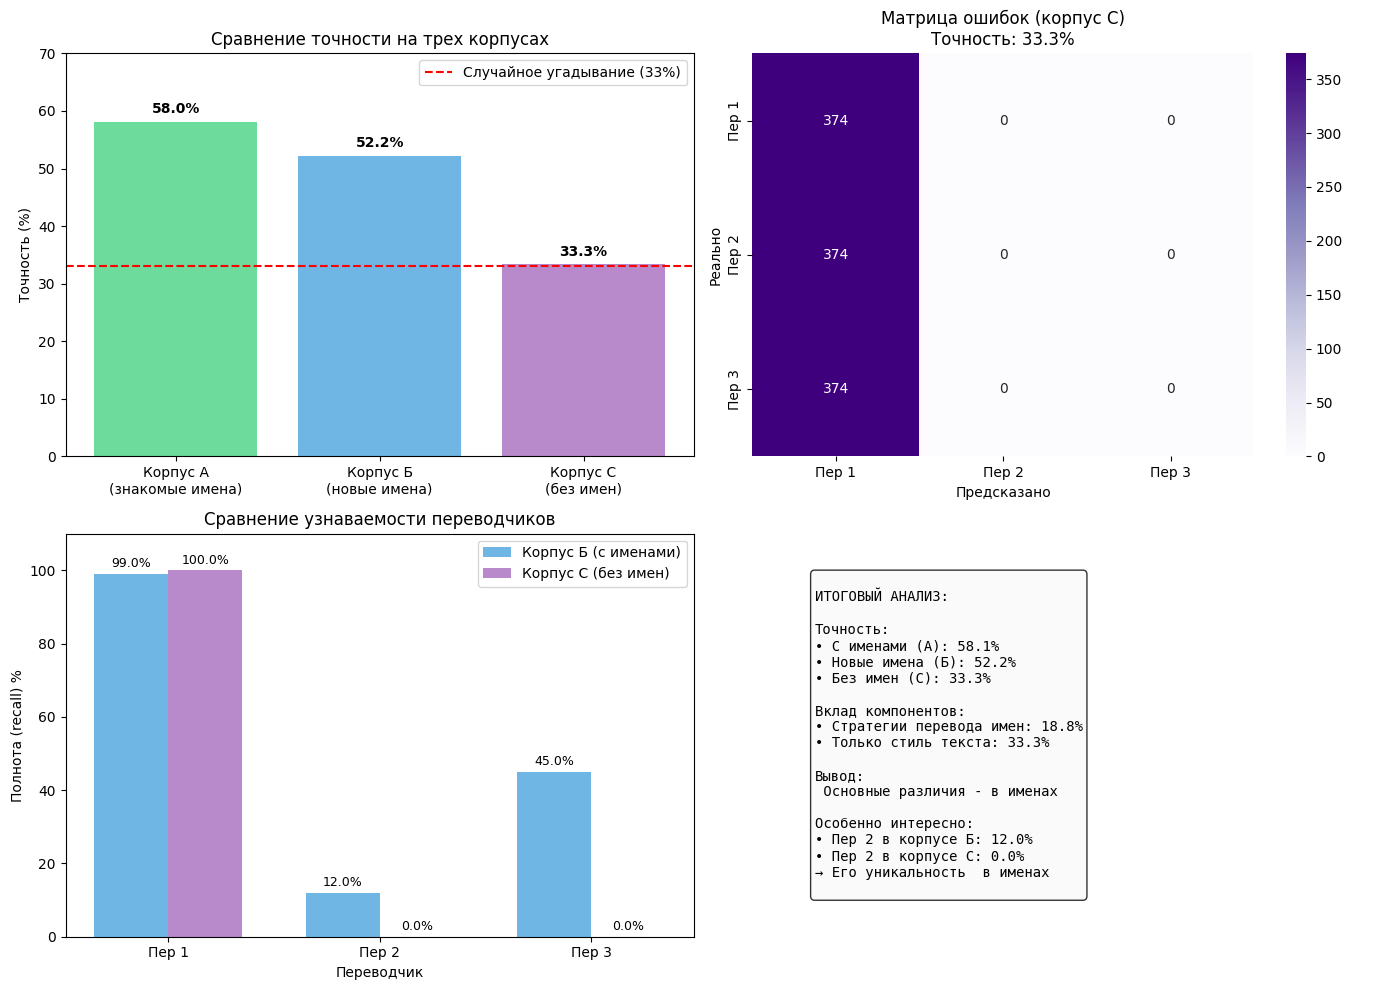

In [30]:

import matplotlib.pyplot as plt
import numpy as np
    
# Создаем фигуру с тремя подграфиками
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
 # 1. Сравнение точности
ax1 = axes[0, 0]
corpora = ['Корпус А\n(знакомые имена)', 'Корпус Б\n(новые имена)', 'Корпус С\n(без имен)']
accuracies = [58.05, 52.17, accuracy_c * 100]
colors = ['#2ecc71', '#3498db', '#9b59b6']
    
bars = ax1.bar(corpora, accuracies, color=colors, alpha=0.7)
ax1.axhline(y=33, color='red', linestyle='--', label='Случайное угадывание (33%)')
ax1.set_ylabel('Точность (%)')
ax1.set_title('Сравнение точности на трех корпусах')
ax1.set_ylim(0, 70)
ax1.legend()
    
# Добавляем значения на столбцы
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
# 2. Матрица ошибок для корпуса С
ax2 = axes[0, 1]
sns.heatmap(cm_c, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Пер 1', 'Пер 2', 'Пер 3'],
            yticklabels=['Пер 1', 'Пер 2', 'Пер 3'],
            ax=ax2)
ax2.set_title(f'Матрица ошибок (корпус С)\nТочность: {accuracy_c:.1%}')
ax2.set_xlabel('Предсказано')
ax2.set_ylabel('Реально')
    
# 3. Сравнение по переводчикам
ax3 = axes[1, 0]
    
# Данные для каждого переводчика в разных корпусах
translators = ['Пер 1', 'Пер 2', 'Пер 3']
    
# Recalls из корпуса Б (ваши данные)
recalls_b = [99.0, 12.0, 45.0]
    
# Recalls из корпуса С (рассчитываем)
recalls_c = []
for t in [1, 2, 3]:
    mask = (y_c_true == t)
    total = np.sum(mask)
    correct = np.sum((y_c_true == t) & (y_c_pred == t))
    recalls_c.append(correct/total * 100 if total > 0 else 0)
    
x = np.arange(len(translators))
width = 0.35
    
bars_b = ax3.bar(x - width/2, recalls_b, width, label='Корпус Б (с именами)', color='#3498db', alpha=0.7)
bars_c = ax3.bar(x + width/2, recalls_c, width, label='Корпус С (без имен)', color='#9b59b6', alpha=0.7)
    
ax3.set_xlabel('Переводчик')
ax3.set_ylabel('Полнота (recall) %')
ax3.set_title('Сравнение узнаваемости переводчиков')
ax3.set_xticks(x)
ax3.set_xticklabels(translators)
ax3.legend()
ax3.set_ylim(0, 110)
    
# Добавляем значения
for bars, values in [(bars_b, recalls_b), (bars_c, recalls_c)]:
    for bar, val in zip(bars, values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
# 4. Текстовый анализ
ax4 = axes[1, 1]
ax4.axis('off')
    
analysis_text = f"""
ИТОГОВЫЙ АНАЛИЗ:
    
Точность:
• С именами (А): 58.1%
• Новые имена (Б): 52.2%
• Без имен (С): {accuracy_c:.1%}
    
Вклад компонентов:
• Стратегии перевода имен: {52.17 - accuracy_c*100:.1f}%
• Только стиль текста: {accuracy_c*100:.1f}%
    
Вывод:
{' Сильный стилистический почерк' if accuracy_c > 0.5 else 
 ' Стиль есть, имена важнее' if accuracy_c > 0.4 else 
 ' Основные различия - в именах'}
    
Особенно интересно:
• Пер 2 в корпусе Б: {recalls_b[1]:.1f}%
• Пер 2 в корпусе С: {recalls_c[1]:.1f}%
{'→ Его уникальность  в именах' if recalls_c[1] < 20 else 
 '→ У него есть стилистические особенности'}
    """
    
ax4.text(0.1, 0.5, analysis_text, fontsize=10, va='center', family='monospace',
        bbox=dict(boxstyle='round', facecolor='#f9f9f9', alpha=0.8))
    
plt.tight_layout()
    
# Сохраняем
viz_path = os.path.join(run_dir, 'corpus_c_analysis.png')
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f" Визуализация сохранена: {viz_path}")
plt.show()
    


In [31]:
# Анализ уверенности предсказаний
# Получаем вероятности для каждого класса
proba_df = pd.DataFrame(y_c_proba, columns=['prob_1', 'prob_2', 'prob_3'])
proba_df['true'] = y_c_true
proba_df['pred'] = y_c_pred
proba_df['correct'] = y_c_true == y_c_pred
proba_df['max_prob'] = proba_df[['prob_1', 'prob_2', 'prob_3']].max(axis=1)

print(f"\n Статистика уверенности:")
print(f"  Средняя уверенность: {proba_df['max_prob'].mean():.2%}")
print(f"  Мин. уверенность: {proba_df['max_prob'].min():.2%}")
print(f"  Макс. уверенность: {proba_df['max_prob'].max():.2%}")

# Уверенность для правильных и неправильных предсказаний
correct_proba = proba_df[proba_df['correct']]['max_prob'].mean()
incorrect_proba = proba_df[~proba_df['correct']]['max_prob'].mean()
print(f"\n  Средняя уверенность (правильные): {correct_proba:.2%}")
print(f"  Средняя уверенность (ошибки): {incorrect_proba:.2%}")

# Тексты с высокой уверенностью
print(f"\n Тексты с высокой уверенностью (>80%):")
high_confidence = proba_df[proba_df['max_prob'] > 0.8].head(5)
for idx in high_confidence.index[:5]:
    if idx < len(text_samples_c):
        sample = text_samples_c[idx]
        print(f"\n  Текст (переводчик {sample['translator']}):")
        print(f"    {sample['text']}")
        print(f"    Предсказано: {proba_df.loc[idx, 'pred']} "
              f"(уверенность: {proba_df.loc[idx, 'max_prob']:.2%})")


 Статистика уверенности:
  Средняя уверенность: 39.48%
  Мин. уверенность: 38.76%
  Макс. уверенность: 41.46%

  Средняя уверенность (правильные): 39.58%
  Средняя уверенность (ошибки): 39.43%

 Тексты с высокой уверенностью (>80%):


In [32]:
# Создаем DataFrame с результатами
results_c = pd.DataFrame({
    'true': y_c_true,
    'pred': y_c_pred,
    'correct': y_c_true == y_c_pred,
    'prob_1': y_c_proba[:, 0],
    'prob_2': y_c_proba[:, 1],
    'prob_3': y_c_proba[:, 2],
})

# Добавляем примеры текстов (первые 100 символов)
text_examples = []
for i in range(len(results_c)):
    if i < len(text_samples_c):
        text_examples.append(text_samples_c[i]['text'])
    else:
        text_examples.append('')

results_c['text_sample'] = text_examples

# Сохраняем результаты
results_c_path = os.path.join(run_dir, 'corpus_c_predictions.xlsx')
results_c.to_excel(results_c_path, index=False)
print(f" Предсказания сохранены: {results_c_path}")

# Сохраняем отчет
report_c_path = os.path.join(run_dir, 'corpus_c_report.txt')
with open(report_c_path, 'w', encoding='utf-8') as f:
    f.write("ОТЧЕТ ПО КОРПУСУ С (МАСКИРОВКА ИМЕН)\n")
    f.write("="*60 + "\n\n")
    f.write(f"Точность: {accuracy_c:.2%}\n\n")
    
    f.write("Сравнение с другими корпусами:\n")
    f.write(f"  Корпус А (знакомые имена): 58.05%\n")
    f.write(f"  Корпус Б (новые имена):    52.17%\n")
    f.write(f"  Корпус С (без имен):        {accuracy_c:.2%}\n")
    f.write(f"  Вклад имен:                 {52.17 - accuracy_c*100:.2f}%\n\n")
    
    f.write("Classification Report:\n")
    f.write(classification_report(y_c_true, y_c_pred))
    f.write("\n")
    
    f.write("Матрица ошибок:\n")
    f.write(str(cm_c))
    f.write("\n")

print(f" Отчет сохранен: {report_c_path}")

 Предсказания сохранены: C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647\corpus_c_predictions.xlsx
 Отчет сохранен: C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647\corpus_c_report.txt


In [33]:
# Вывод по всем трем корпусам

print(f"""


Корпус А (знакомые имена):    58.05% │ Базовое обучение
Корпус Б (новые имена):       52.17% │ Обобщение стратегий перевода имен
Корпус С (без имен):           {accuracy_c:.2%} │ Чистый стиль текста

────────────────────────────────────────────────
Вклад компонентов в определение переводчика:

• Имена (конкретные):          {58.05 - 52.17:.2f}%
• Стратегии перевода имен:     {52.17 - accuracy_c*100:.2f}%
• Чистый стиль текста:         {accuracy_c*100:.2f}%
────────────────────────────────────────────────
ИТОГО:                          100%
""")

print("\n ИНТЕРПРЕТАЦИЯ:")

if accuracy_c > 0.5:
    print("   У переводчиков сильный стилистический почерк")
    print("     Их можно узнать без имен")
elif accuracy_c > 0.45:
    print("   Хороший стилистический почерк")
    print("     Имена важны, но стиль тоже хорошо различим")
elif accuracy_c > 0.4:

    print("     Основные различия - в переводе имен")
else:
    print("     Без имен переводчики почти неразличимы")

print(f"\n Все результаты сохранены в:\n{run_dir}")





Корпус А (знакомые имена):    58.05% │ Базовое обучение
Корпус Б (новые имена):       52.17% │ Обобщение стратегий перевода имен
Корпус С (без имен):           33.33% │ Чистый стиль текста

────────────────────────────────────────────────
Вклад компонентов в определение переводчика:

• Имена (конкретные):          5.88%
• Стратегии перевода имен:     18.84%
• Чистый стиль текста:         33.33%
────────────────────────────────────────────────
ИТОГО:                          100%


 ИНТЕРПРЕТАЦИЯ:
     Без имен переводчики почти неразличимы

 Все результаты сохранены в:
C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\run_20260219_223647
